In [1]:
!pip install dacon_submit_api-0.0.4-py3-none-any.whl

Processing ./dacon_submit_api-0.0.4-py3-none-any.whl
dacon-submit-api is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.


In [2]:
#cd54fb1ab20010c1d742bd9789ca793fa6a83ebf47efb0818cbe576baf14f873

In [3]:
import pandas as pd
import numpy as np
import gc

import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
import psutil
import os

def get_memory_usage_mb():
    process = psutil.Process(os.getpid())
    mem_bytes = process.memory_info().rss  # ÌòÑÏû¨ ÌîÑÎ°úÏÑ∏Ïä§Ïùò Ïã§Ï†ú Î©îÎ™®Î¶¨ ÏÇ¨Ïö©Îüâ
    return mem_bytes / 1024 ** 2  # MB Îã®ÏúÑÎ°ú Î≥ÄÌôò

In [1]:
import pandas as pd
import gc

class CARD_container():
    def __init__(self):
        self.data_splits = ["train", "test"]
        self.data_categories = {
            "ÌöåÏõêÏ†ïÎ≥¥": {"folder": "1.ÌöåÏõêÏ†ïÎ≥¥", "suffix": "ÌöåÏõêÏ†ïÎ≥¥", "var_prefix": "customer"},
            "Ïã†Ïö©Ï†ïÎ≥¥": {"folder": "2.Ïã†Ïö©Ï†ïÎ≥¥", "suffix": "Ïã†Ïö©Ï†ïÎ≥¥", "var_prefix": "credit"},
            "ÏäπÏù∏Îß§Ï∂úÏ†ïÎ≥¥": {"folder": "3.ÏäπÏù∏Îß§Ï∂úÏ†ïÎ≥¥", "suffix": "ÏäπÏù∏Îß§Ï∂úÏ†ïÎ≥¥", "var_prefix": "sales"},
            "Ï≤≠Íµ¨Ï†ïÎ≥¥": {"folder": "4.Ï≤≠Íµ¨ÏûÖÍ∏àÏ†ïÎ≥¥", "suffix": "Ï≤≠Íµ¨Ï†ïÎ≥¥", "var_prefix": "billing"},
            "ÏûîÏï°Ï†ïÎ≥¥": {"folder": "5.ÏûîÏï°Ï†ïÎ≥¥", "suffix": "ÏûîÏï°Ï†ïÎ≥¥", "var_prefix": "balance"},
            "Ï±ÑÎÑêÏ†ïÎ≥¥": {"folder": "6.Ï±ÑÎÑêÏ†ïÎ≥¥", "suffix": "Ï±ÑÎÑêÏ†ïÎ≥¥", "var_prefix": "channel"},
            "ÎßàÏºÄÌåÖÏ†ïÎ≥¥": {"folder": "7.ÎßàÏºÄÌåÖÏ†ïÎ≥¥", "suffix": "ÎßàÏºÄÌåÖÏ†ïÎ≥¥", "var_prefix": "marketing"},
            "ÏÑ±Í≥ºÏ†ïÎ≥¥": {"folder": "8.ÏÑ±Í≥ºÏ†ïÎ≥¥", "suffix": "ÏÑ±Í≥ºÏ†ïÎ≥¥", "var_prefix": "performance"}
        }
        self.months = ['07', '08', '09', '10', '11', '12']
        self.data = {}       
        self.train_data = {} 
        self.test_data = {}  
    @staticmethod
    def get_memory_usage_mb():
        process = psutil.Process(os.getpid())
        return process.memory_info().rss / 1024 ** 2
        


    def load_final_data(self, train_path=None, test_path=None):
        """train_final, test_final Îç∞Ïù¥ÌÑ∞Î•º Î∂àÎü¨Ïò§Îäî Î©îÏÑúÎìú"""
        if train_path:
            df = pd.read_parquet(train_path)
            self.train_data = {'train_merged_all': df}
            print(f"‚úÖ train_final.parquet Î°úÎî© ÏôÑÎ£å, shape: {df.shape}")

        if test_path:
            df = pd.read_parquet(test_path)
            self.test_data = {'test_merged_all': df}
            print(f"‚úÖ test_final.parquet Î°úÎî© ÏôÑÎ£å, shape: {df.shape}")
        
    def get_data(self, path='/home/cksgh8511/ÌÇ§ÏõÄ/card', months=['07'], data_splits=["train", "test"]):
        for split in data_splits:
            for category, info in self.data_categories.items():
                folder = info["folder"]
                suffix = info["suffix"]
                var_prefix = info["var_prefix"]

                for month in months:
                    file_path = f"{path}/{split}/{folder}/2018{month}_{split}_{suffix}.parquet"
                    variable_name = f"{var_prefix}_{split}_{month}"

                    try:
                        if split == 'train':
                            self.train_data[variable_name] = pd.read_parquet(file_path)
                            print(f"{variable_name} is loaded from {file_path}")
                        elif split == 'test':
                            self.test_data[variable_name] = pd.read_parquet(file_path)
                            print(f"{variable_name} is loaded from {file_path}")
                    except Exception as e:
                        print(f"Failed to load {file_path}: {e}")

        gc.collect()

    def merge_train_data(self, months=None):
        """Ïó¨Îü¨ monthÏóê ÎåÄÌï¥ train Îç∞Ïù¥ÌÑ∞ ÌÜµÌï©"""
        if months is None:
            months = self.months  # default: ['07', ..., '12']

        for month in months:
            print(f"\nüõ†Ô∏è [Train] {month}Ïõî Îç∞Ïù¥ÌÑ∞ ÌÜµÌï© ÏãúÏûë")

            self.get_memory_usage_mb()

            customer_key = f'customer_train_{month}'
            credit_key = f'credit_train_{month}'

            if customer_key not in self.train_data or credit_key not in self.train_data:
                print(f"‚ùó {customer_key} ÎòêÎäî {credit_key}Í∞Ä ÏóÜÏäµÎãàÎã§. Ïä§ÌÇµÌï©ÎãàÎã§.")
                continue

            train_df = self.train_data[customer_key].merge(
                self.train_data[credit_key], on=['Í∏∞Ï§ÄÎÖÑÏõî', 'ID'], how='left'
            )
            print(f"Step1 Ï†ÄÏû• ÏôÑÎ£å: {customer_key} + {credit_key}, shape: {train_df.shape}")

            del self.train_data[customer_key]
            del self.train_data[credit_key]
            gc.collect()

            merge_sequence = [
                ("sales", "Step2"),
                ("billing", "Step3"),
                ("balance", "Step4"),
                ("channel", "Step5"),
                ("marketing", "Step6"),
                ("performance", "ÏµúÏ¢Ö")
            ]

            for prefix, step_name in merge_sequence:
                df_key = f'{prefix}_train_{month}'

                if df_key not in self.train_data:
                    print(f"Warning: {df_key} ÏóÜÏùå. {step_name} Îã®Í≥Ñ Ïä§ÌÇµ.")
                    continue

                train_df = train_df.merge(
                    self.train_data[df_key], on=['Í∏∞Ï§ÄÎÖÑÏõî', 'ID'], how='left'
                )
                print(f"{step_name} Ï†ÄÏû• ÏôÑÎ£å: merge {df_key}, shape: {train_df.shape}")

                del self.train_data[df_key]
                gc.collect()

            self.get_memory_usage_mb()

            self.train_data[f'train_merged_{month}'] = train_df
            print(f"‚úÖ ÏµúÏ¢Ö ÌÜµÌï© ÏôÑÎ£å: train_merged_{month}, shape: {train_df.shape}")

    def merge_test_data(self, months=None):
        """Ïó¨Îü¨ monthÏóê ÎåÄÌï¥ test Îç∞Ïù¥ÌÑ∞ ÌÜµÌï©"""
        if months is None:
            months = self.months

        for month in months:
            print(f"\nüõ†Ô∏è [Test] {month}Ïõî Îç∞Ïù¥ÌÑ∞ ÌÜµÌï© ÏãúÏûë")

            self.get_memory_usage_mb()

            customer_key = f'customer_test_{month}'
            credit_key = f'credit_test_{month}'

            if customer_key not in self.test_data or credit_key not in self.test_data:
                print(f"‚ùó {customer_key} ÎòêÎäî {credit_key}Í∞Ä ÏóÜÏäµÎãàÎã§. Ïä§ÌÇµÌï©ÎãàÎã§.")
                continue

            test_df = self.test_data[customer_key].merge(
                self.test_data[credit_key], on=['Í∏∞Ï§ÄÎÖÑÏõî', 'ID'], how='left'
            )
            print(f"Step1 Ï†ÄÏû• ÏôÑÎ£å: {customer_key} + {credit_key}, shape: {test_df.shape}")

            del self.test_data[customer_key]
            del self.test_data[credit_key]
            gc.collect()

            merge_sequence = [
                ("sales", "Step2"),
                ("billing", "Step3"),
                ("balance", "Step4"),
                ("channel", "Step5"),
                ("marketing", "Step6"),
                ("performance", "ÏµúÏ¢Ö")
            ]

            for prefix, step_name in merge_sequence:
                df_key = f'{prefix}_test_{month}'

                if df_key not in self.test_data:
                    print(f"Warning: {df_key} ÏóÜÏùå. {step_name} Îã®Í≥Ñ Ïä§ÌÇµ.")
                    continue

                test_df = test_df.merge(
                    self.test_data[df_key], on=['Í∏∞Ï§ÄÎÖÑÏõî', 'ID'], how='left'
                )
                print(f"{step_name} Ï†ÄÏû• ÏôÑÎ£å: merge {df_key}, shape: {test_df.shape}")

                del self.test_data[df_key]
                gc.collect()

            self.get_memory_usage_mb()

            self.test_data[f'test_merged_{month}'] = test_df
            print(f"‚úÖ ÏµúÏ¢Ö ÌÜµÌï© ÏôÑÎ£å: test_merged_{month}, shape: {test_df.shape}")
    
    def concat_merged_train_data(self, months=None):
        """Ïó¨Îü¨ ÏõîÏùò train_merged Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏùÑ ÌïòÎÇòÎ°ú ÌÜµÌï©"""
        if months is None:
            months = self.months

        dfs = []
        for month in months:
            key = f"train_merged_{month}"
            if key in self.train_data:
                dfs.append(self.train_data[key])
            else:
                print(f"‚ö†Ô∏è {key} ÏóÜÏùå. Ïä§ÌÇµÌï©ÎãàÎã§.")

        if not dfs:
            print("‚ùå Î≥ëÌï©Ìï† Îç∞Ïù¥ÌÑ∞Í∞Ä ÏóÜÏäµÎãàÎã§.")
            return None

        full_df = pd.concat(dfs, axis=0, ignore_index=True)
        self.train_data['train_merged_all'] = full_df
        print(f"\nüéØ Ï†ÑÏ≤¥ ÌÜµÌï© ÏôÑÎ£å: train_merged_all, shape: {full_df.shape}")
        return full_df   
    
    def concat_merged_test_data(self, months=None):
        """Ïó¨Îü¨ ÏõîÏùò test_merged Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏùÑ ÌïòÎÇòÎ°ú ÌÜµÌï©"""
        if months is None:
            months = self.months

        dfs = []
        for month in months:
            key = f"test_merged_{month}"
            if key in self.test_data:
                dfs.append(self.test_data[key])
            else:
                print(f"‚ö†Ô∏è {key} ÏóÜÏùå. Ïä§ÌÇµÌï©ÎãàÎã§.")

        if not dfs:
            print("‚ùå Î≥ëÌï©Ìï† test Îç∞Ïù¥ÌÑ∞Í∞Ä ÏóÜÏäµÎãàÎã§.")
            return None

        full_df = pd.concat(dfs, axis=0, ignore_index=True)
        self.test_data['test_merged_all'] = full_df
        print(f"\nüéØ Ï†ÑÏ≤¥ ÌÜµÌï© ÏôÑÎ£å: test_merged_all, shape: {full_df.shape}")
        return full_df
    

In [2]:
import pandas as pd

class CARD_EDA():
    def __init__(self, card_container):
        self.card_container = card_container
        self.data_types = ['customer','credit', 'sales', 'billing', 'balance', 'channel', 'marketing', 'performance']

    

    def get_columns(self, dfs='train'):

        if dfs == 'train':
            dfs = self.card_container.train_data
        elif dfs == 'test':
            dfs = self.card_container.test_data

        for name, df in dfs.items():
            print(f"\n[{name} Ïª¨Îüº Î™©Î°ù] ({df.shape[1]} columns)")
            print(df.columns.tolist())

    def print_unique(self, dfs='train', drop=True):
        def get_unique_info_for_df(series):
            value_counts = series.value_counts(dropna=False)
            return pd.Series({
                'n_unique': series.nunique(dropna=False),
                'value_counts': value_counts.to_dict()
            })

        if dfs == 'train':
            dfs = self.card_container.train_data
        elif dfs == 'test':
            dfs = self.card_container.test_data

        for key, value in self.constant_features_dict.items():
            
            result_df = dfs[key][value].apply(get_unique_info_for_df).T
            print(key)
            if result_df.empty:
                print("Empty ")
            else:
                print(result_df)

    def get_constant_feature(self, dfs='train', drop=False):
        if dfs == 'train':
            dfs = self.card_container.train_data
        elif dfs == 'test':
            dfs = self.card_container.test_data

        constant_features_dict = {}

        for name, df in dfs.items():
            constant_features = [
                col for col in df.columns
                if df[col].nunique(dropna=False) <= 1 and col != 'Í∏∞Ï§ÄÎÖÑÏõî'
            ]
            constant_features_dict[name] = constant_features
            if drop:
                df.drop(columns=constant_features, inplace=True)

            print(f"[{name}] ÏÉÅÏàò feature Í∞úÏàò (Í∏∞Ï§ÄÎÖÑÏõî Ï†úÏô∏): {len(constant_features)}Í∞ú")
            if constant_features:
                print(" -", constant_features)
            else:
                print(" - ÏóÜÏùå")

        self.constant_features_dict = constant_features_dict
    
    def get_date_features(self, dfs='train', drop=False):
        """ ÎÇ†ÏßúÌòï featureÎ•º Ï∞æÏïÑ Ï†úÍ±∞ÌïòÎäî Î©îÏÑúÎìú """
        if dfs == 'train':
            dfs = self.card_container.train_data
        elif dfs == 'test':
            dfs = self.card_container.test_data

        date_features_dict = {}

        for name, df in dfs.items():
            date_features = [
                col for col in df.columns
                if (pd.api.types.is_datetime64_any_dtype(df[col]) or 'date' in col.lower() or 'ÏùºÏûê' in col)
            ]
            date_features_dict[name] = date_features
            if drop:
                df.drop(columns=date_features, inplace=True)

            print(f"[{name}] ÎÇ†ÏßúÌòï feature Í∞úÏàò: {len(date_features)}Í∞ú")
            if date_features:
                print(" -", date_features)
            else:
                print(" - ÏóÜÏùå")

        self.date_features_dict = date_features_dict

    def get_high_single_value_features(self, dfs='train', threshold=0.95, drop=False):
        """ Í≤∞Ï∏°Ïπò ÎòêÎäî Îã®ÏùºÍ∞íÏù¥ 95% Ïù¥ÏÉÅÏù∏ feature Ï†úÍ±∞ÌïòÎäî Î©îÏÑúÎìú """
        if dfs == 'train':
            dfs = self.card_container.train_data
        elif dfs == 'test':
            dfs = self.card_container.test_data

        high_single_value_features_dict = {}

        for name, df in dfs.items():
            high_single_features = []

            for col in df.columns:
                if df[col].isna().mean() >= threshold:
                    high_single_features.append(col)
                else:
                    top_freq = df[col].value_counts(normalize=True, dropna=False).values[0]
                    if top_freq >= threshold:
                        high_single_features.append(col)

            high_single_value_features_dict[name] = high_single_features

            if drop:
                df.drop(columns=high_single_features, inplace=True)

            print(f"[{name}] 95% Ïù¥ÏÉÅ Í≤∞Ï∏°/Îã®ÏùºÍ∞í feature Í∞úÏàò: {len(high_single_features)}Í∞ú")
            if high_single_features:
                print(" -", high_single_features)
            else:
                print(" - ÏóÜÏùå")

        self.high_single_value_features_dict = high_single_value_features_dict


In [3]:
card_container = CARD_container()

# Í∏∞Ï°¥ get_data()Îäî ÏïÑÏòà Ïïà Ïì∞Í≥†
card_container.load_final_data(
    train_path="/home/cksgh8511/ÌÇ§ÏõÄ/card/train_final.parquet",
    test_path="/home/cksgh8511/ÌÇ§ÏõÄ/card/test_final.parquet"
)

# Ïù¥ÌõÑ EDA ÏãúÏûë
card_eda = CARD_EDA(card_container)

card_eda.get_columns(dfs='train')
card_eda.get_constant_feature(dfs='train')

‚úÖ train_final.parquet Î°úÎî© ÏôÑÎ£å, shape: (2400000, 858)
‚úÖ test_final.parquet Î°úÎî© ÏôÑÎ£å, shape: (600000, 857)

[train_merged_all Ïª¨Îüº Î™©Î°ù] (858 columns)
['Í∏∞Ï§ÄÎÖÑÏõî', 'ID', 'ÎÇ®ÎÖÄÍµ¨Î∂ÑÏΩîÎìú', 'Ïó∞Î†π', 'Segment', 'ÌöåÏõêÏó¨Î∂Ä_Ïù¥Ïö©Í∞ÄÎä•', 'ÌöåÏõêÏó¨Î∂Ä_Ïù¥Ïö©Í∞ÄÎä•_CA', 'ÌöåÏõêÏó¨Î∂Ä_Ïù¥Ïö©Í∞ÄÎä•_Ïπ¥ÎìúÎ°†', 'ÏÜåÏßÄÏó¨Î∂Ä_Ïã†Ïö©', 'ÏÜåÏßÄÏπ¥ÎìúÏàò_Ïú†Ìö®_Ïã†Ïö©', 'ÏÜåÏßÄÏπ¥ÎìúÏàò_Ïù¥Ïö©Í∞ÄÎä•_Ïã†Ïö©', 'ÏûÖÌöåÏùºÏûê_Ïã†Ïö©', 'ÏûÖÌöåÍ≤ΩÍ≥ºÍ∞úÏõîÏàò_Ïã†Ïö©', 'ÌöåÏõêÏó¨Î∂Ä_Ïó∞Ï≤¥', 'Ïù¥Ïö©Í±∞Ï†àÏó¨Î∂Ä_Ïπ¥ÎìúÎ°†', 'ÎèôÏùòÏó¨Î∂Ä_ÌïúÎèÑÏ¶ùÏï°ÏïàÎÇ¥', 'ÏàòÏã†Í±∞Î∂ÄÏó¨Î∂Ä_TM', 'ÏàòÏã†Í±∞Î∂ÄÏó¨Î∂Ä_DM', 'ÏàòÏã†Í±∞Î∂ÄÏó¨Î∂Ä_Î©îÏùº', 'ÏàòÏã†Í±∞Î∂ÄÏó¨Î∂Ä_SMS', 'Í∞ÄÏûÖÌÜµÏã†ÌöåÏÇ¨ÏΩîÎìú', 'ÌÉàÌöåÌöüÏàò_ÎàÑÏ†Å', 'ÏµúÏ¢ÖÌÉàÌöåÌõÑÍ≤ΩÍ≥ºÏõî', 'ÌÉàÌöåÌöüÏàò_Î∞úÍ∏â6Í∞úÏõîÏù¥ÎÇ¥', 'ÌÉàÌöåÌöüÏàò_Î∞úÍ∏â1ÎÖÑÏù¥ÎÇ¥', 'Í±∞Ï£ºÏãúÎèÑÎ™Ö', 'ÏßÅÏû•ÏãúÎèÑÎ™Ö', 'ÎßàÏºÄÌåÖÎèôÏùòÏó¨Î∂Ä', 'Ïú†Ìö®Ïπ¥ÎìúÏàò_Ïã†Ïö©Ï≤¥ÌÅ¨', 'Ïú†Ìö®Ïπ¥ÎìúÏàò_Ïã†Ïö©', 'Ïú†Ìö®Ïπ¥ÎìúÏàò_Ïã†Ïö©_Í∞ÄÏ°±', 'Ïú†Ìö®Ïπ¥ÎìúÏàò_Ï≤

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from itertools import product
from xgboost.callback import EarlyStopping


class XGBModelManager:
    def __init__(self, df, target_col, drop_cols=None, test_size=0.2, random_state=42, pre = True):
        self.df = df.copy()
        self.target_col = target_col
        self.drop_cols = drop_cols if drop_cols else ['Í∏∞Ï§ÄÎÖÑÏõî', 'ID']
        self.test_size = test_size
        self.random_state = random_state
        self.label_encoders = {}
        self.model = None
        self.X_train = None
        self.X_val = None
        self.y_train = None
        self.y_val = None
        self.evals_result = None

        
        if pre == True:
            self._prepare_data()

    def _prepare_data(self):
        X = self.df.drop(columns=self.drop_cols + [self.target_col])
        y = self.df[self.target_col]

        for col in X.columns:
            if X[col].dtype == 'object':
                le = LabelEncoder()
                X[col] = le.fit_transform(X[col].astype(str))
                self.label_encoders[col] = le

        le_y = LabelEncoder()
        y = le_y.fit_transform(y)
        self.label_encoders[self.target_col] = le_y

        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(
            X, y,
            test_size=self.test_size,
            random_state=self.random_state,
            stratify=y
        )
        print(f"‚úÖ Îç∞Ïù¥ÌÑ∞ Î∂ÑÎ¶¨ ÏôÑÎ£å: X_train {self.X_train.shape}, X_val {self.X_val.shape}")

    def train_model(self, features=None, early_stopping_rounds=30, grid_search=False, param_grid=None, params=None):
        if features is not None:
            X_train = self.X_train[features]
            X_val = self.X_val[features]
            self.selected_features = features
        else:
            X_train = self.X_train
            X_val = self.X_val
            self.selected_features = X_train.columns.tolist()

        base_params = {
            'tree_method': 'hist',
            'max_bin': 256,
            'random_state': self.random_state,
            'eval_metric': 'mlogloss'
        }
        if params:
            base_params.update(params)

        if not grid_search:
            self.model = xgb.XGBClassifier(**base_params)
            self.model.fit(
                X_train, self.y_train,
                eval_set=[(X_train, self.y_train), (X_val, self.y_val)],
                callbacks=[EarlyStopping(rounds=early_stopping_rounds)],  # Î∞òÎìúÏãú callbacksÎ°ú!
                verbose=True
            )
            self.evals_result = self.model.evals_result()
            print(f"‚úÖ Î™®Îç∏ ÌïôÏäµ ÏôÑÎ£å (features: {features if features else 'Ï†ÑÏ≤¥'})")
        else:
            print("üöÄ Í∑∏Î¶¨Îîî ÏÑúÏπò ÏãúÏûëÌï©ÎãàÎã§...")
            best_score = float('inf')
            best_params = None
            best_model = None

            keys = list(param_grid.keys())
            for values in product(*param_grid.values()):
                trial_params = dict(zip(keys, values))
                trial_params.update(base_params)

                model = xgb.XGBClassifier(**trial_params)
                model.fit(
                    X_train, self.y_train,
                    eval_set=[(X_train, self.y_train), (X_val, self.y_val)],
                    
                    verbose=False
                )
                evals_result = model.evals_result()
                val_score = evals_result['validation_1']['mlogloss'][-1]

                print(f"üîç Tried {trial_params} ‚Üí val_mlogloss = {val_score:.5f}")

                if val_score < best_score:
                    best_score = val_score
                    best_params = trial_params
                    best_model = model

            self.model = best_model
            self.evals_result = best_model.evals_result()
            self.best_params = best_params  # Ï∂îÍ∞Ä Ï†ÄÏû•
            print(f"‚úÖ Best params found: {best_params}")
            print(f"‚úÖ Best validation mlogloss: {best_score:.5f}")

    def plot_loss(self):
        if not self.evals_result:
            print("‚ùó ÌïôÏäµ Í≤∞Í≥ºÍ∞Ä ÏóÜÏäµÎãàÎã§. Î®ºÏ†Ä Î™®Îç∏ÏùÑ ÌïôÏäµÌïòÏÑ∏Ïöî.")
            return

        train_loss = self.evals_result['validation_0']['mlogloss']
        val_loss = self.evals_result['validation_1']['mlogloss']

        plt.figure(figsize=(10, 6))
        plt.plot(train_loss, label='Train Loss (mlogloss)')
        plt.plot(val_loss, label='Validation Loss (mlogloss)')
        plt.xlabel('Iteration')
        plt.ylabel('Log Loss')
        plt.title('Training vs Validation Loss')
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_feature_importance(self, max_num_features=20):
        if not self.model:
            print("‚ùó Î™®Îç∏Ïù¥ ÏóÜÏäµÎãàÎã§. Î®ºÏ†Ä ÌïôÏäµÌïòÏÑ∏Ïöî.")
            return

        xgb.plot_importance(
            self.model,
            max_num_features=max_num_features,
            importance_type='gain',
            height=0.5
        )
        plt.title("Feature Importance")
        plt.grid(True)
        plt.show()

    def evaluate_model(self):
        if self.model is None:
            print("‚ùó Î™®Îç∏Ïù¥ ÏóÜÏäµÎãàÎã§. Î®ºÏ†Ä ÌïôÏäµÌïòÏÑ∏Ïöî.")
            return

        X_val_selected = self.X_val[self.selected_features]  # <--- Ïó¨Í∏∞!
        y_pred = self.model.predict(X_val_selected)

        acc = accuracy_score(self.y_val, y_pred)
        f1 = f1_score(self.y_val, y_pred, average='weighted')

        print(f"Accuracy: {acc:.4f}")
        print(f"F1 Score: {f1:.4f}")
        
    def get_feature_importance_df(self, importance_type='gain'):
        """Feature ImportanceÎ•º DataFrameÏúºÎ°ú Ï†ïÎ¶¨Ìï¥ÏÑú Ï§ëÏöîÎèÑ ÎÜíÏùÄ ÏàúÏúºÎ°ú Î∞òÌôò"""
        if self.model is None:
            print("‚ùó Î™®Îç∏Ïù¥ ÏóÜÏäµÎãàÎã§. Î®ºÏ†Ä ÌïôÏäµÌïòÏÑ∏Ïöî.")
            return None

        booster = self.model.get_booster()
        score_dict = booster.get_score(importance_type=importance_type)

        # f0, f1, f2 ‚Üí X_train.columns Îß§Ìïë
        importance_data = []
        for fname, importance in score_dict.items():
            idx = int(fname[1:])  # 'f12' ‚Üí 12
            col_name = self.X_train.columns[idx]
            importance_data.append((col_name, importance))

        # DataFrameÏúºÎ°ú Î≥ÄÌôò
        importance_df = pd.DataFrame(importance_data, columns=['feature', 'importance'])

        # Ï§ëÏöîÎèÑ ÎÜíÏùÄ ÏàúÏúºÎ°ú Ï†ïÎ†¨
        importance_df = importance_df.sort_values(by='importance', ascending=False).reset_index(drop=True)

        return importance_df


In [32]:
card_container.train_data['train_merged_all'].head()

Í∏∞Ï§ÄÎÖÑÏõî            ID  ÎÇ®ÎÖÄÍµ¨Î∂ÑÏΩîÎìú   Ïó∞Î†π Segment  ÌöåÏõêÏó¨Î∂Ä_Ïù¥Ïö©Í∞ÄÎä•  ÌöåÏõêÏó¨Î∂Ä_Ïù¥Ïö©Í∞ÄÎä•_CA  \
0  201807  TRAIN_000000       2  40ÎåÄ       D          1             1   
1  201807  TRAIN_000001       1  30ÎåÄ       E          1             1   
2  201807  TRAIN_000002       1  30ÎåÄ       C          1             1   
3  201807  TRAIN_000003       2  40ÎåÄ       D          1             1   
4  201807  TRAIN_000004       2  40ÎåÄ       E          1             1   

   ÌöåÏõêÏó¨Î∂Ä_Ïù¥Ïö©Í∞ÄÎä•_Ïπ¥ÎìúÎ°†  ÏÜåÏßÄÏó¨Î∂Ä_Ïã†Ïö©  ÏÜåÏßÄÏπ¥ÎìúÏàò_Ïú†Ìö®_Ïã†Ïö©  ...  Î≥ÄÎèôÎ•†_RVÏùºÏãúÎ∂àÌèâÏûî  Î≥ÄÎèôÎ•†_Ìï†Î∂ÄÌèâÏûî  Î≥ÄÎèôÎ•†_CAÌèâÏûî  \
0              0        1            1  ...     0.999998  1.042805  0.999700   
1              1        1            1  ...     1.092698  0.905663  0.999998   
2              0        1            1  ...     1.006124  1.993590  0.852567   
3              0        1            2  ...     0.999998  1.050646  0.999877   
4              1        1            1  ...     0.999998  0.999998  0.999998   

   Î≥ÄÎèôÎ•†_RVCAÌèâÏûî  Î≥ÄÎèôÎ•†_Ïπ¥ÎìúÎ°†ÌèâÏûî  Î≥ÄÎèôÎ•†_ÏûîÏï°_B1M  Î≥ÄÎèôÎ•†_ÏûîÏï°_ÏùºÏãúÎ∂à_B1M  Î≥ÄÎèôÎ•†_ÏûîÏï°_CA_B1M  \
0    0.999998   0.999998    0.261886        0.270752       0.000000   
1    0.999998   0.999998   -0.563388       -0.670348       0.000000   
2    0.999998   0.999998   -0.046516        0.058114      -0.014191   
3    0.999998   0.999998    0.023821        0.258943       0.000000   
4    0.999998   0.999998    0.000000        0.000000       0.000000   

   ÌòúÌÉùÏàòÌòúÏú®_R3M  ÌòúÌÉùÏàòÌòúÏú®_B0M  
0   1.044401   1.280543  
1   0.000000   0.000000  
2   0.524159   1.208420  
3   0.880925   1.657124  
4        NaN        NaN  

[5 rows x 750 columns]

‚úÖ Îç∞Ïù¥ÌÑ∞ Î∂ÑÎ¶¨ ÏôÑÎ£å: X_train (1920000, 747), X_val (480000, 747)
[0]	validation_0-mlogloss:1.09390	validation_1-mlogloss:1.09422
[1]	validation_0-mlogloss:0.84464	validation_1-mlogloss:0.84509
[2]	validation_0-mlogloss:0.68697	validation_1-mlogloss:0.68755
[3]	validation_0-mlogloss:0.58019	validation_1-mlogloss:0.58094
[4]	validation_0-mlogloss:0.50488	validation_1-mlogloss:0.50585
[5]	validation_0-mlogloss:0.45009	validation_1-mlogloss:0.45125
[6]	validation_0-mlogloss:0.40959	validation_1-mlogloss:0.41102
[7]	validation_0-mlogloss:0.37935	validation_1-mlogloss:0.38103
[8]	validation_0-mlogloss:0.35598	validation_1-mlogloss:0.35794
[9]	validation_0-mlogloss:0.33731	validation_1-mlogloss:0.33946
[10]	validation_0-mlogloss:0.32284	validation_1-mlogloss:0.32526
[11]	validation_0-mlogloss:0.31124	validation_1-mlogloss:0.31387
[12]	validation_0-mlogloss:0.30181	validation_1-mlogloss:0.30465
[13]	validation_0-mlogloss:0.29361	validation_1-mlogloss:0.29669
[14]	validation_0-mlogloss:

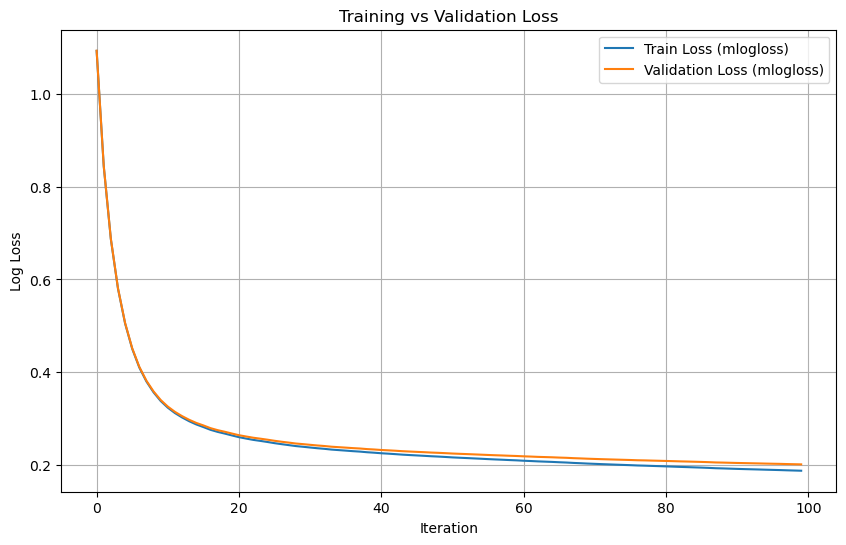

/home/cksgh8511/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51077 (\N{HANGUL SYLLABLE IB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/cksgh8511/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 54924 (\N{HANGUL SYLLABLE HOE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/cksgh8511/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44221 (\N{HANGUL SYLLABLE GYEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/cksgh8511/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44284 (\N{HANGUL SYLLABLE GWA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/cksgh8511/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) miss

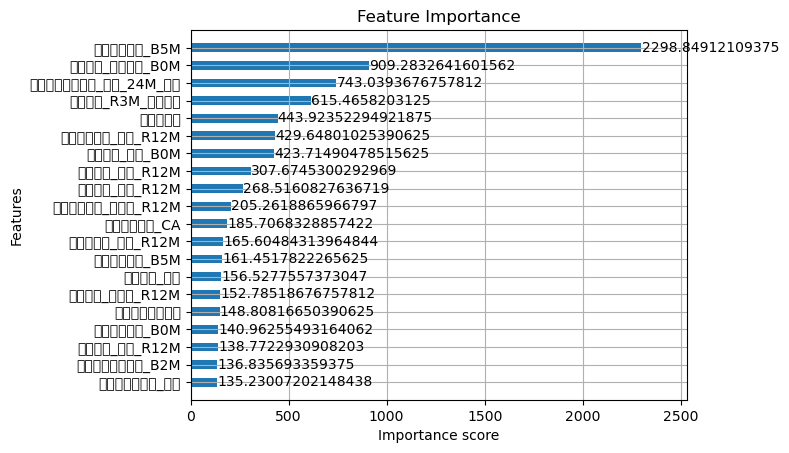

Accuracy: 0.9224
F1 Score: 0.9208


In [33]:
# 1. Îß§ÎãàÏ†Ä ÏÉùÏÑ±
manager = XGBModelManager(card_container.train_data['train_merged_all'], target_col='Segment')

# 2. Ï†ÑÏ≤¥ featureÎ°ú ÌïôÏäµ
manager.train_model()

# 3. loss Í∑∏ÎûòÌîÑ
manager.plot_loss()

# 4. feature importance
manager.plot_feature_importance()

# 5. Î™®Îç∏ ÌèâÍ∞Ä (Accuracy, F1 score, Confusion Matrix)
manager.evaluate_model()



In [ ]:
# manager2 = XGBModelManager(card_container.train_data['train_merged_all'], target_col='Segment')
# manager2.label_encoders = manager.label_encoders
# manager2.model = manager.model
# manager2.X_train = manager.X_train
# manager2.X_val = manager.X_val
# manager2.y_train = manager.y_train
# manager2.y_val = manager.y_val
# manager2.evals_result = manager.evals_result

In [34]:
# 6. ÌäπÏ†ï featureÎßå Í≥®ÎùºÏÑú Ïû¨ÌïôÏäµ (ex: Ï§ëÏöîÌïú ÏÉÅÏúÑ 10Í∞ú featureÎßå)
booster = manager.model.get_booster()
score_dict = booster.get_score(importance_type='gain')
print(score_dict)
# dictÎ•º DataFrameÏúºÎ°ú Î≥ÄÌôò
importance_features_df = pd.DataFrame({
    'feature': list(score_dict.keys()),
    'importance': list(score_dict.values())
})

# Ï§ëÏöîÎèÑ ÎÜíÏùÄ ÏàúÏúºÎ°ú Ï†ïÎ†¨
importance_features_df = importance_features_df.sort_values(by='importance', ascending=False).reset_index(drop=True)

importance_features_df



{'ÎÇ®ÎÖÄÍµ¨Î∂ÑÏΩîÎìú': 11.254607200622559, 'Ïó∞Î†π': 19.390625, 'ÌöåÏõêÏó¨Î∂Ä_Ïù¥Ïö©Í∞ÄÎä•': 22.409698486328125, 'ÌöåÏõêÏó¨Î∂Ä_Ïù¥Ïö©Í∞ÄÎä•_CA': 46.006317138671875, 'ÌöåÏõêÏó¨Î∂Ä_Ïù¥Ïö©Í∞ÄÎä•_Ïπ¥ÎìúÎ°†': 19.161449432373047, 'ÏÜåÏßÄÏó¨Î∂Ä_Ïã†Ïö©': 16.742549896240234, 'ÏÜåÏßÄÏπ¥ÎìúÏàò_Ïú†Ìö®_Ïã†Ïö©': 74.20176696777344, 'ÏÜåÏßÄÏπ¥ÎìúÏàò_Ïù¥Ïö©Í∞ÄÎä•_Ïã†Ïö©': 31.23121452331543, 'ÏûÖÌöåÏùºÏûê_Ïã†Ïö©': 156.5277557373047, 'ÏûÖÌöåÍ≤ΩÍ≥ºÍ∞úÏõîÏàò_Ïã†Ïö©': 135.23007202148438, 'ÌöåÏõêÏó¨Î∂Ä_Ïó∞Ï≤¥': 4.732019424438477, 'Ïù¥Ïö©Í±∞Ï†àÏó¨Î∂Ä_Ïπ¥ÎìúÎ°†': 13.29603385925293, 'ÎèôÏùòÏó¨Î∂Ä_ÌïúÎèÑÏ¶ùÏï°ÏïàÎÇ¥': 26.869735717773438, 'ÏàòÏã†Í±∞Î∂ÄÏó¨Î∂Ä_TM': 22.013904571533203, 'ÏàòÏã†Í±∞Î∂ÄÏó¨Î∂Ä_DM': 12.234664916992188, 'ÏàòÏã†Í±∞Î∂ÄÏó¨Î∂Ä_Î©îÏùº': 62.290870666503906, 'ÏàòÏã†Í±∞Î∂ÄÏó¨Î∂Ä_SMS': 27.072328567504883, 'Í∞ÄÏûÖÌÜµÏã†ÌöåÏÇ¨ÏΩîÎìú': 13.680379867553711, 'ÌÉàÌöåÌöüÏàò_ÎàÑÏ†Å': 9.524048805236816, 'ÏµúÏ¢ÖÌÉàÌöåÌõÑÍ≤ΩÍ≥ºÏõî': 7.090384006500244, 'ÌÉàÌöåÌöüÏàò_Î∞úÍ∏â6Í∞úÏõîÏù¥ÎÇ¥': 22.030622482299805, 'ÌÉ

feature   importance
0            Ï†ïÏÉÅÏ≤≠Íµ¨ÏõêÍ∏à_B5M  2298.849121
1         Ïù¥Ïö©Í∏àÏï°_Ïò§ÌîÑÎùºÏù∏_B0M   909.283264
2    Ïó∞ÏÜçÏú†Ïã§Ï†ÅÍ∞úÏõîÏàò_Í∏∞Î≥∏_24M_Ïπ¥Îìú   743.039368
3         Ïù¥Ïö©Í∏àÏï°_R3M_Ïã†Ïö©Ï≤¥ÌÅ¨   615.465820
4                 Ïù¥Ïö©Í∏àÏï°ÎåÄ   443.923523
..                  ...          ...
611       Ï¶ùÍ∞ê_RPÍ±¥Ïàò_Î†åÌÉà_Ï†ÑÏõî     0.649094
612     ÏäπÏù∏Í±∞Ï†àÍ±¥Ïàò_ÌïúÎèÑÏ¥àÍ≥º_B0M     0.620087
613            _3ÏàúÏúÑÎÇ©Î∂ÄÏóÖÏ¢Ö     0.569933
614        Ïù¥Ïö©Í∏àÏï°_DÌéòÏù¥_B0M     0.306501
615       Ï¶ùÍ∞ê_RPÍ±¥Ïàò_Î≥¥Ìóò_Ï†ÑÏõî     0.210785

[616 rows x 2 columns]

In [35]:
list(importance_features_df['feature'][:20])

['Ï†ïÏÉÅÏ≤≠Íµ¨ÏõêÍ∏à_B5M',
 'Ïù¥Ïö©Í∏àÏï°_Ïò§ÌîÑÎùºÏù∏_B0M',
 'Ïó∞ÏÜçÏú†Ïã§Ï†ÅÍ∞úÏõîÏàò_Í∏∞Î≥∏_24M_Ïπ¥Îìú',
 'Ïù¥Ïö©Í∏àÏï°_R3M_Ïã†Ïö©Ï≤¥ÌÅ¨',
 'Ïù¥Ïö©Í∏àÏï°ÎåÄ',
 'ÏµúÎåÄÏù¥Ïö©Í∏àÏï°_Ï≤¥ÌÅ¨_R12M',
 'Ïù¥Ïö©Í∏àÏï°_Ï≤¥ÌÅ¨_B0M',
 'Ïù¥Ïö©Í∏àÏï°_Ï≤¥ÌÅ¨_R12M',
 'Ïù¥Ïö©Í±¥Ïàò_Ïã†Ïö©_R12M',
 'ÏµúÎåÄÏù¥Ïö©Í∏àÏï°_ÏùºÏãúÎ∂à_R12M',
 'ÏµúÏ¢ÖÏù¥Ïö©ÏùºÏûê_CA',
 'Ïù¥Ïö©Í∞úÏõîÏàò_Ïã†Ïö©_R12M',
 'Ïó∞Ï≤¥ÏûÖÍ∏àÏõêÍ∏à_B5M',
 'ÏûÖÌöåÏùºÏûê_Ïã†Ïö©',
 'Ïù¥Ïö©Í∏àÏï°_ÏùºÏãúÎ∂à_R12M',
 'ÏõîÏÉÅÌôòÎ°†ÌïúÎèÑÍ∏àÏï°',
 'Ï†ïÏÉÅÏ≤≠Íµ¨ÏõêÍ∏à_B0M',
 'Ïù¥Ïö©Í∏àÏï°_Ìï†Î∂Ä_R12M',
 'Ïπ¥ÎìúÏù¥Ïö©ÌïúÎèÑÍ∏àÏï°_B2M',
 'ÏûÖÌöåÍ≤ΩÍ≥ºÍ∞úÏõîÏàò_Ïã†Ïö©']

[0]	validation_0-mlogloss:1.09408	validation_1-mlogloss:1.09436
[1]	validation_0-mlogloss:0.84517	validation_1-mlogloss:0.84566
[2]	validation_0-mlogloss:0.68821	validation_1-mlogloss:0.68888
[3]	validation_0-mlogloss:0.58178	validation_1-mlogloss:0.58260
[4]	validation_0-mlogloss:0.50684	validation_1-mlogloss:0.50780
[5]	validation_0-mlogloss:0.45269	validation_1-mlogloss:0.45379
[6]	validation_0-mlogloss:0.41294	validation_1-mlogloss:0.41424
[7]	validation_0-mlogloss:0.38286	validation_1-mlogloss:0.38431
[8]	validation_0-mlogloss:0.36049	validation_1-mlogloss:0.36210
[9]	validation_0-mlogloss:0.34326	validation_1-mlogloss:0.34508
[10]	validation_0-mlogloss:0.33003	validation_1-mlogloss:0.33205
[11]	validation_0-mlogloss:0.31850	validation_1-mlogloss:0.32070
[12]	validation_0-mlogloss:0.30974	validation_1-mlogloss:0.31207
[13]	validation_0-mlogloss:0.30220	validation_1-mlogloss:0.30470
[14]	validation_0-mlogloss:0.29675	validation_1-mlogloss:0.29944
[15]	validation_0-mlogloss:0.28997	

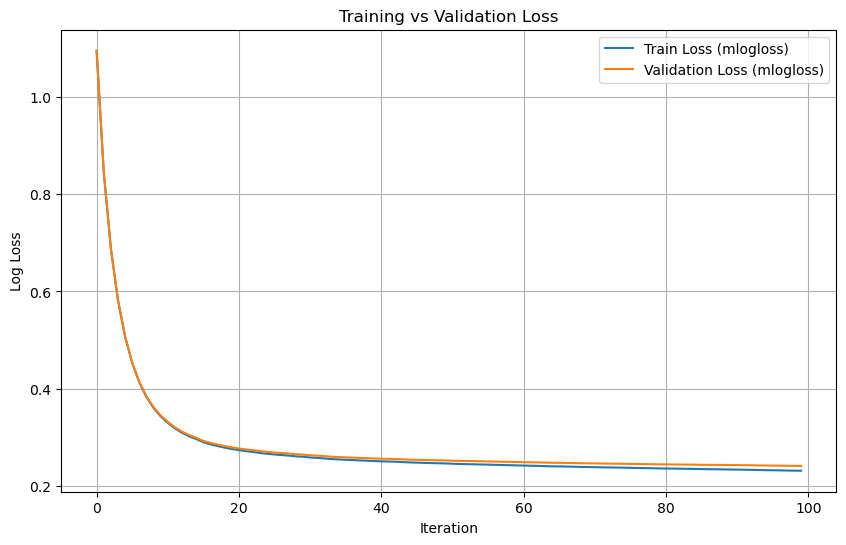

In [37]:

manager.train_model(features=list(importance_features_df['feature'][:20]))
manager.evaluate_model()

# 3. loss Í∑∏ÎûòÌîÑ
manager.plot_loss()


In [47]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

class SubmissionManager:
    def __init__(self, manager, card_container):
        self.manager = manager
        self.card_container = card_container

    def _encode_object_columns(self, df):
        """
        object ÌÉÄÏûÖ Ïª¨ÎüºÏùÑ Label Encoding
        """
        for col in df.select_dtypes(include='object').columns:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))
        return df

    def predict_and_save(self, test_df_name="test_merged_all", id_column="ID", output_path="./submission.csv"):
        if self.manager.model is None:
            raise ValueError("‚ùó manager ÏïàÏóê Î™®Îç∏Ïù¥ ÏóÜÏäµÎãàÎã§. Î®ºÏ†Ä ÌïôÏäµÌïòÏÑ∏Ïöî.")

        if test_df_name not in self.card_container.test_data:
            raise ValueError(f"‚ùó card_container.test_data ÏïàÏóê {test_df_name} Ïù¥ ÏóÜÏäµÎãàÎã§.")

        # 1. test Îç∞Ïù¥ÌÑ∞
        test_df = self.card_container.test_data[test_df_name]

        # 2. feature ÏÑ†ÌÉù
        if hasattr(self.manager, 'selected_features') and self.manager.selected_features is not None:
            X_test = test_df[self.manager.selected_features].copy()
        else:
            X_test = test_df[self.manager.X_train.columns.tolist()].copy()

        # 3. object ÌÉÄÏûÖ Ïª¨Îüº Label Encoding
        X_test = self._encode_object_columns(X_test)

        # 4. ÏòàÏ∏°
        y_test_pred = self.manager.model.predict(X_test)

        # 5. ÎîîÏΩîÎî©
    
        y_test_pred_labels = self.manager.label_encoders[self.manager.target_col].inverse_transform(y_test_pred)

        # 6. Í≤∞Í≥º Ï∂îÍ∞Ä
        test_data = test_df.copy()
        test_data["pred_label"] = y_test_pred_labels

        # 7. ID Îã®ÏúÑÎ°ú Voting
        submission = test_data.groupby(id_column)["pred_label"] \
            .agg(lambda x: x.value_counts().idxmax()) \
            .reset_index()

        submission.columns = [id_column, "Segment"]

        # 8. Ï†ÄÏû•
        submission.to_csv(output_path, index=False)
        print(f"‚úÖ Submission file saved to {output_path}")

        return submission


‚úÖ Îç∞Ïù¥ÌÑ∞ Î∂ÑÎ¶¨ ÏôÑÎ£å: X_train (1920000, 747), X_val (480000, 747)
[0]	validation_0-mlogloss:1.09390	validation_1-mlogloss:1.09422
[1]	validation_0-mlogloss:0.84464	validation_1-mlogloss:0.84509
[2]	validation_0-mlogloss:0.68697	validation_1-mlogloss:0.68755
[3]	validation_0-mlogloss:0.58019	validation_1-mlogloss:0.58094
[4]	validation_0-mlogloss:0.50488	validation_1-mlogloss:0.50585
[5]	validation_0-mlogloss:0.45009	validation_1-mlogloss:0.45125
[6]	validation_0-mlogloss:0.40959	validation_1-mlogloss:0.41102
[7]	validation_0-mlogloss:0.37935	validation_1-mlogloss:0.38103
[8]	validation_0-mlogloss:0.35598	validation_1-mlogloss:0.35794
[9]	validation_0-mlogloss:0.33731	validation_1-mlogloss:0.33946
[10]	validation_0-mlogloss:0.32284	validation_1-mlogloss:0.32526
[11]	validation_0-mlogloss:0.31124	validation_1-mlogloss:0.31387
[12]	validation_0-mlogloss:0.30181	validation_1-mlogloss:0.30465
[13]	validation_0-mlogloss:0.29361	validation_1-mlogloss:0.29669
[14]	validation_0-mlogloss:

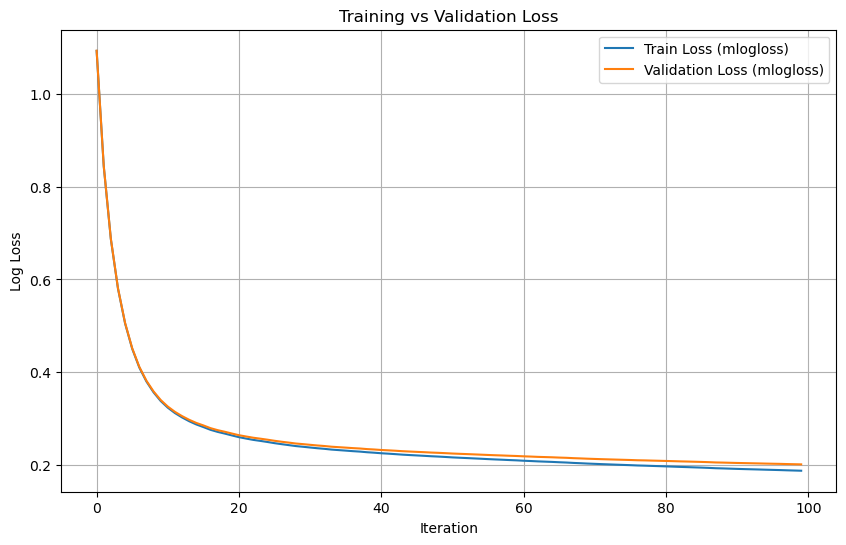

/home/cksgh8511/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51077 (\N{HANGUL SYLLABLE IB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/cksgh8511/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 54924 (\N{HANGUL SYLLABLE HOE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/cksgh8511/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44221 (\N{HANGUL SYLLABLE GYEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/cksgh8511/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44284 (\N{HANGUL SYLLABLE GWA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/cksgh8511/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) miss

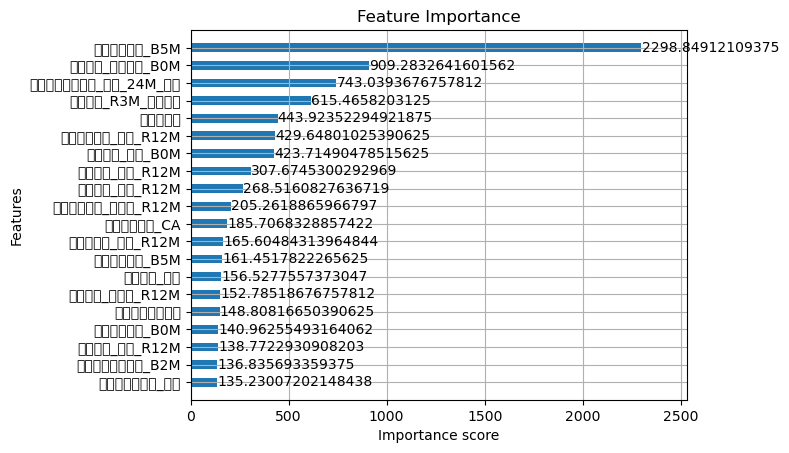

Accuracy: 0.9224
F1 Score: 0.9208


In [39]:
# 1. Îß§ÎãàÏ†Ä ÏÉùÏÑ±
manager = XGBModelManager(card_container.train_data['train_merged_all'], target_col='Segment')

# 2. Ï†ÑÏ≤¥ featureÎ°ú ÌïôÏäµ
manager.train_model()

# 3. loss Í∑∏ÎûòÌîÑ
manager.plot_loss()

# 4. feature importance
manager.plot_feature_importance()

# 5. Î™®Îç∏ ÌèâÍ∞Ä (Accuracy, F1 score, Confusion Matrix)
manager.evaluate_model()



In [49]:
# 6. ÌäπÏ†ï featureÎßå Í≥®ÎùºÏÑú Ïû¨ÌïôÏäµ (ex: Ï§ëÏöîÌïú ÏÉÅÏúÑ 10Í∞ú featureÎßå)
booster = manager.model.get_booster()
score_dict = booster.get_score(importance_type='gain')
print(score_dict)
# dictÎ•º DataFrameÏúºÎ°ú Î≥ÄÌôò
importance_features_df = pd.DataFrame({
    'feature': list(score_dict.keys()),
    'importance': list(score_dict.values())
})

# Ï§ëÏöîÎèÑ ÎÜíÏùÄ ÏàúÏúºÎ°ú Ï†ïÎ†¨
importance_features_df = importance_features_df.sort_values(by='importance', ascending=False).reset_index(drop=True)

importance_features_df



{'ÎÇ®ÎÖÄÍµ¨Î∂ÑÏΩîÎìú': 11.254607200622559, 'Ïó∞Î†π': 19.390625, 'ÌöåÏõêÏó¨Î∂Ä_Ïù¥Ïö©Í∞ÄÎä•': 22.409698486328125, 'ÌöåÏõêÏó¨Î∂Ä_Ïù¥Ïö©Í∞ÄÎä•_CA': 46.006317138671875, 'ÌöåÏõêÏó¨Î∂Ä_Ïù¥Ïö©Í∞ÄÎä•_Ïπ¥ÎìúÎ°†': 19.161449432373047, 'ÏÜåÏßÄÏó¨Î∂Ä_Ïã†Ïö©': 16.742549896240234, 'ÏÜåÏßÄÏπ¥ÎìúÏàò_Ïú†Ìö®_Ïã†Ïö©': 74.20176696777344, 'ÏÜåÏßÄÏπ¥ÎìúÏàò_Ïù¥Ïö©Í∞ÄÎä•_Ïã†Ïö©': 31.23121452331543, 'ÏûÖÌöåÏùºÏûê_Ïã†Ïö©': 156.5277557373047, 'ÏûÖÌöåÍ≤ΩÍ≥ºÍ∞úÏõîÏàò_Ïã†Ïö©': 135.23007202148438, 'ÌöåÏõêÏó¨Î∂Ä_Ïó∞Ï≤¥': 4.732019424438477, 'Ïù¥Ïö©Í±∞Ï†àÏó¨Î∂Ä_Ïπ¥ÎìúÎ°†': 13.29603385925293, 'ÎèôÏùòÏó¨Î∂Ä_ÌïúÎèÑÏ¶ùÏï°ÏïàÎÇ¥': 26.869735717773438, 'ÏàòÏã†Í±∞Î∂ÄÏó¨Î∂Ä_TM': 22.013904571533203, 'ÏàòÏã†Í±∞Î∂ÄÏó¨Î∂Ä_DM': 12.234664916992188, 'ÏàòÏã†Í±∞Î∂ÄÏó¨Î∂Ä_Î©îÏùº': 62.290870666503906, 'ÏàòÏã†Í±∞Î∂ÄÏó¨Î∂Ä_SMS': 27.072328567504883, 'Í∞ÄÏûÖÌÜµÏã†ÌöåÏÇ¨ÏΩîÎìú': 13.680379867553711, 'ÌÉàÌöåÌöüÏàò_ÎàÑÏ†Å': 9.524048805236816, 'ÏµúÏ¢ÖÌÉàÌöåÌõÑÍ≤ΩÍ≥ºÏõî': 7.090384006500244, 'ÌÉàÌöåÌöüÏàò_Î∞úÍ∏â6Í∞úÏõîÏù¥ÎÇ¥': 22.030622482299805, 'ÌÉ

feature   importance
0            Ï†ïÏÉÅÏ≤≠Íµ¨ÏõêÍ∏à_B5M  2298.849121
1         Ïù¥Ïö©Í∏àÏï°_Ïò§ÌîÑÎùºÏù∏_B0M   909.283264
2    Ïó∞ÏÜçÏú†Ïã§Ï†ÅÍ∞úÏõîÏàò_Í∏∞Î≥∏_24M_Ïπ¥Îìú   743.039368
3         Ïù¥Ïö©Í∏àÏï°_R3M_Ïã†Ïö©Ï≤¥ÌÅ¨   615.465820
4                 Ïù¥Ïö©Í∏àÏï°ÎåÄ   443.923523
..                  ...          ...
611       Ï¶ùÍ∞ê_RPÍ±¥Ïàò_Î†åÌÉà_Ï†ÑÏõî     0.649094
612     ÏäπÏù∏Í±∞Ï†àÍ±¥Ïàò_ÌïúÎèÑÏ¥àÍ≥º_B0M     0.620087
613            _3ÏàúÏúÑÎÇ©Î∂ÄÏóÖÏ¢Ö     0.569933
614        Ïù¥Ïö©Í∏àÏï°_DÌéòÏù¥_B0M     0.306501
615       Ï¶ùÍ∞ê_RPÍ±¥Ïàò_Î≥¥Ìóò_Ï†ÑÏõî     0.210785

[616 rows x 2 columns]

In [ ]:
"""
class XGBModelManager:
    def __init__(self, df, target_col, drop_cols=None, test_size=0.2, random_state=42, pre = True):
        self.df = df.copy()
        self.target_col = target_col
        self.drop_cols = drop_cols if drop_cols else ['Í∏∞Ï§ÄÎÖÑÏõî', 'ID']
        self.test_size = test_size
        self.random_state = random_state
        self.label_encoders = {}
        self.model = None
        self.X_train = None
        self.X_val = None
        self.y_train = None
        self.y_val = None
        self.evals_result = None
"""

In [84]:

manager_impor = XGBModelManager(card_container.train_data['train_merged_all'], target_col='Segment', pre = True)




‚úÖ Îç∞Ïù¥ÌÑ∞ Î∂ÑÎ¶¨ ÏôÑÎ£å: X_train (1920000, 747), X_val (480000, 747)


üöÄ Í∑∏Î¶¨Îîî ÏÑúÏπò ÏãúÏûëÌï©ÎãàÎã§...
üîç Tried {'max_depth': 13, 'learning_rate': 0.3, 'subsample': 1.0, 'tree_method': 'hist', 'max_bin': 256, 'random_state': 42, 'eval_metric': 'mlogloss'} ‚Üí val_mlogloss = 0.17109
üîç Tried {'max_depth': 13, 'learning_rate': 0.5, 'subsample': 1.0, 'tree_method': 'hist', 'max_bin': 256, 'random_state': 42, 'eval_metric': 'mlogloss'} ‚Üí val_mlogloss = 0.17267
üîç Tried {'max_depth': 13, 'learning_rate': 0.8, 'subsample': 1.0, 'tree_method': 'hist', 'max_bin': 256, 'random_state': 42, 'eval_metric': 'mlogloss'} ‚Üí val_mlogloss = 0.18687
üîç Tried {'max_depth': 14, 'learning_rate': 0.3, 'subsample': 1.0, 'tree_method': 'hist', 'max_bin': 256, 'random_state': 42, 'eval_metric': 'mlogloss'} ‚Üí val_mlogloss = 0.16998
üîç Tried {'max_depth': 14, 'learning_rate': 0.5, 'subsample': 1.0, 'tree_method': 'hist', 'max_bin': 256, 'random_state': 42, 'eval_metric': 'mlogloss'} ‚Üí val_mlogloss = 0.17331
üîç Tried {'max_depth': 14, 'learning_rate': 0.8

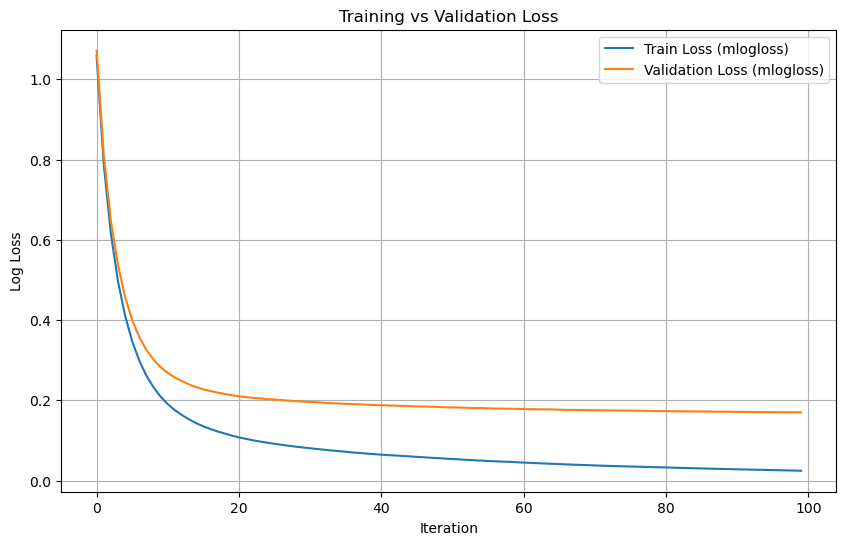

In [93]:
param_grid = {
    'max_depth': [13, 14, 15],
    'learning_rate': [0.3,0.5,0.8],
    'subsample': [1.0]
}

manager_impor.train_model(
    features=list(importance_features_df['feature'][:30]),
    grid_search=True,
    param_grid=param_grid,
    
)

# 3. loss Í∑∏ÎûòÌîÑ
manager_impor.plot_loss()

In [76]:
import xgboost
print(xgboost.__version__)

3.0.0


In [94]:
# 1. ÌÅ¥ÎûòÏä§ ÏÉùÏÑ±
submission_manager = SubmissionManager(manager_impor, card_container)

# 2. predict + save
submission_df = submission_manager.predict_and_save(
    test_df_name="test_merged_all",  # card_container.test_dataÏóê Ïù¥ Ïù¥Î¶ÑÏù¥ ÏûàÏñ¥Ïïº Ìï®
    id_column="ID",
    output_path="./base_submit.csv"
)


‚úÖ Submission file saved to ./base_submit.csv


In [95]:
from dacon_submit_api import dacon_submit_api 

result = dacon_submit_api.post_submission_file(
'/home/cksgh8511/ÌÇ§ÏõÄ/card/sample_submission.csv', 
'cd54fb1ab20010c1d742bd9789ca793fa6a83ebf47efb0818cbe576baf14f873', 
'236460', 
'whyrinari_chano', 
'submission: 1Ï∞® Ï†Ñ ÌîºÏ≥ê ÌïôÏäµ - ÏÉÅÏàò ÌîºÏ≥ê Ï†úÍ±∞' )

{'isSubmitted': True, 'detail': 'Success'}
